# 0 前置作業

In [ ]:
from datetime import datetime
from dateutil.relativedelta import *
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
assert sklearn.__version__ >= '0.20'
import math
import os
import sys
import matplotlib.pyplot as plt
import yellowbrick
import statsmodels
import tensorflow as tf
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
#from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
try:
    from google.colab import drive, files
    in_colab = True
except ModuleNotFoundError:
    in_colab = False

if in_colab:
    home_dir = ''
    drive.mount('/content/drive')
    groot_dir = '/content/drive/My Drive/kaggle/creditcard/'
else:
    from pathlib import Path
    home_dir = str(Path.home())
    groot_dir = home_dir + '/Google Drive/kaggle/creditcard/'

print('\nRunning on %s' % sys.platform)
print('Python Version', sys.version)

Mounted at /content/drive

Running on linux
Python Version 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


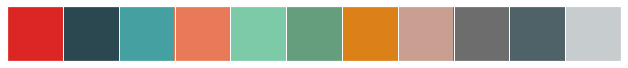

In [ ]:
color = ['#dc2624', '#2b4750', '#45a0a2', '#e87a59','#7dcaa9', '#649E7D', '#dc8018', '#C89F91', '#6c6d6c', '#4f6268', '#c7cccf']
sns.set_palette(color)
sns.set_style('darkgrid',{'axes.facecolor':'#F5F5F5'});
sns.palplot(sns.color_palette())

## 0.1 讀取資料

> It contains only numerical input variables which are the result of a PCA transformation.

1. V1~V28都是經過PCA轉換產生。
2. Time單位為秒。
3. Amount為交易金額。

In [ ]:
creditcard = pd.read_csv(os.path.join(groot_dir, 'creditcard.csv'))
creditcard.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


## 0.2 初步分析

### 0.2.1 確認資料分佈

#### Class

資料類別極度不平衡，建模時需納入資料平衡方法，如SMOTE。

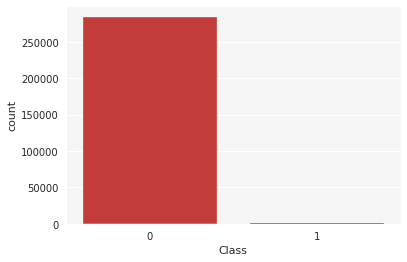

In [ ]:
plt.figure(figsize=(6,4));
sns.countplot(data=creditcard, x='Class');

In [ ]:
creditcard['Class'].value_counts()/len(creditcard)

0    0.998273
1    0.001727
Name: Class, dtype: float64

#### Time

1. Fraud資料看起來沒有特別的時間分佈。
2. 資料有明顯的大眾活動時間(09:00~23:00)，但Fraud資料沒有此現象。
3. 經後續測試，認為Time對模型幫助不大，不採用Time相關特徵。

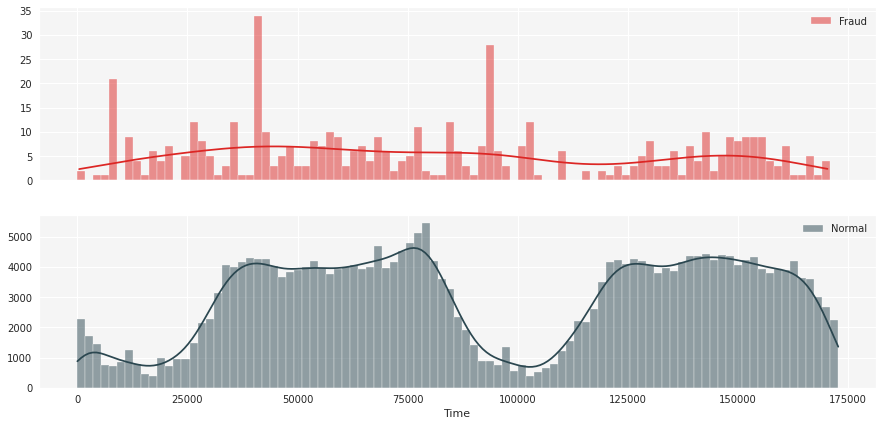

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15,7), sharex=True);
bin = np.linspace(0,(24*60*60*2),96) #每半小時做一個bin
sns.histplot(creditcard.Time[creditcard['Class'] == 1], bins=bin, kde=True, ax=ax[0], color = color[0], label = 'Fraud');
ax[0].set_ylabel('');
ax[0].legend();
sns.histplot(creditcard.Time[creditcard['Class'] == 0], bins=bin, kde=True, ax=ax[1], color = color[1], label= 'Normal');
ax[1].set_ylabel('');
ax[1].legend();

In [ ]:
%%time
import datetime
creditcard['DateTime'] = datetime.datetime(2021,1,1,0,0,0) + pd.to_timedelta(creditcard['Time'],unit='s')
creditcard['Hour'] = creditcard['DateTime'].dt.hour
creditcard['Minute'] = creditcard['DateTime'].dt.minute

hourinterval = []
for i in range(len(creditcard)):
    t = creditcard.loc[i,'Hour']
    hourinterval.append('%d:00' % t)
creditcard['HourInterval'] = hourinterval

halfhourinterval = []
for i in range(len(creditcard)):
    t = creditcard.loc[i,'Hour']
    halfhourinterval.append('%d:00~%d:29' % (t,t) if (creditcard.loc[i,'Minute'] < 30) else ('%d:30~%d:59' % (t,t)))
creditcard['HourInterval_Half'] = halfhourinterval

CPU times: user 7.17 s, sys: 23.1 ms, total: 7.2 s
Wall time: 7.22 s


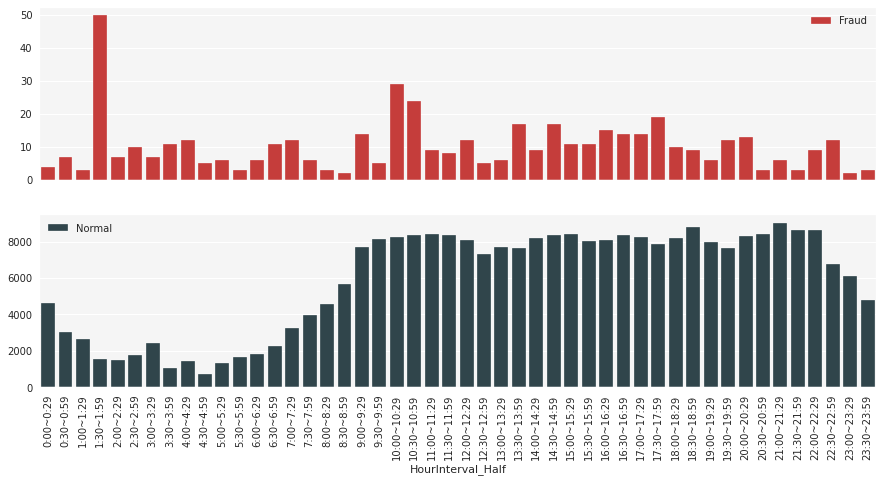

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15,7), sharex=True);
sns.countplot(creditcard.HourInterval_Half[creditcard['Class'] == 1], ax=ax[0], color = color[0], label = 'Fraud');
ax[0].set_ylabel('');
ax[0].set_xlabel('');
ax[0].legend();
sns.countplot(creditcard.HourInterval_Half[creditcard['Class'] == 0], ax=ax[1], color = color[1], label= 'Normal');
ax[1].set_ylabel('');
ax[1].legend();
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);

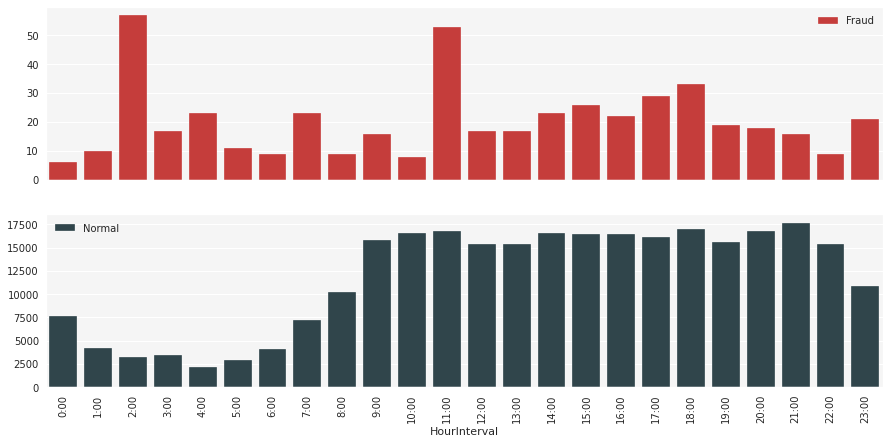

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15,7), sharex=True);
sns.countplot(creditcard.HourInterval[creditcard['Class'] == 1], ax=ax[0], color = color[0], label = 'Fraud');
ax[0].set_ylabel('');
ax[0].set_xlabel('');
ax[0].legend();
sns.countplot(creditcard.HourInterval[creditcard['Class'] == 0], ax=ax[1], color = color[1], label= 'Normal');
ax[1].set_ylabel('');
ax[1].legend();
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);

#### Amount

1. Amount資料偏態明顯
2. 詐欺的金額相較是小數目



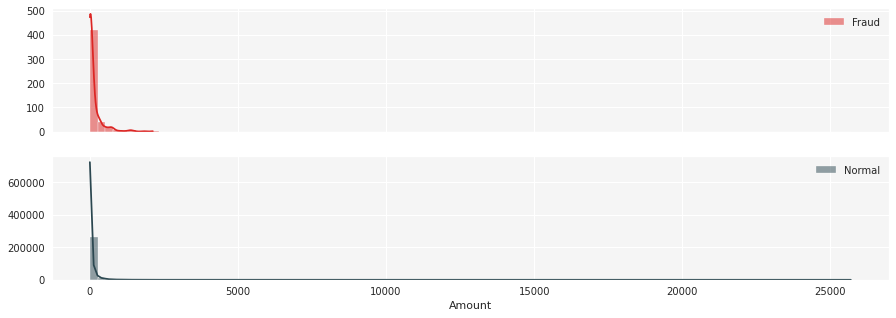

In [ ]:
def checkhist(featurename):
    fig, ax = plt.subplots(2, 1, figsize=(15,5), sharex=True);
    bin = np.linspace(creditcard[featurename].min(),creditcard[featurename].max(),100)
    sns.histplot(creditcard[creditcard['Class'] == 1][featurename], bins=bin, kde=True, ax=ax[0], color = color[0], label = 'Fraud');
    ax[0].set_ylabel('');
    ax[0].legend();
    sns.histplot(creditcard[creditcard['Class'] == 0][featurename], bins=bin, kde=True, ax=ax[1], color = color[1], label= 'Normal');
    ax[1].set_ylabel('');
    ax[1].legend();

checkhist('Amount')

In [ ]:
creditcard.groupby('Class')['Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


### 0.2.2 相關性

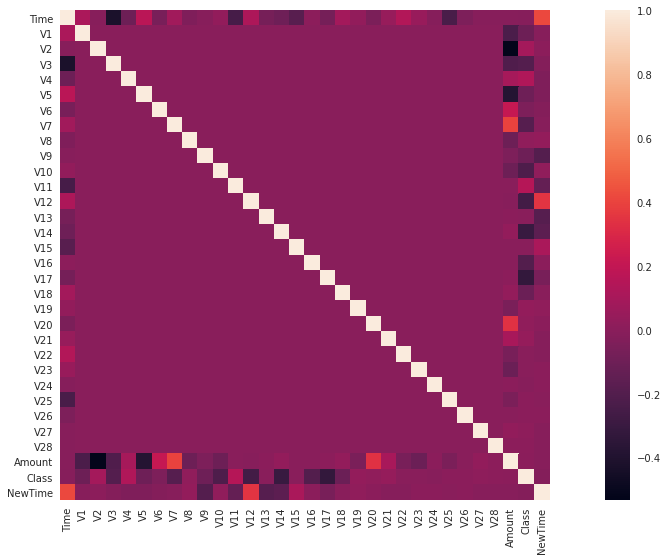

In [ ]:
corrmatrix = creditcard.corr()
fig, ax = plt.subplots(figsize=(20, 9));
sns.heatmap(corrmatrix, square=True);

V7和V20跟Amount相關性相對高，但也都低於0.5

In [ ]:
corrmatrix.loc['Amount'].sort_values(ascending=False)[:5]

Amount    1.000000
V7        0.397311
V20       0.339403
V6        0.215981
V21       0.105999
Name: Amount, dtype: float64

### 0.2.3 distplot

看哪些特徵在class 0和1的區別較大\
最後挑出3、4、10、11、12、14、16、17、18。

In [ ]:
def checkdist(featurename):
    fig, ax = plt.subplots(figsize=(15,3), sharex=True);
    bin = np.linspace(creditcard[featurename].min(),creditcard[featurename].max(),100)
    sns.distplot(creditcard[creditcard['Class'] == 1][featurename], bins=bin, kde=True, ax=ax, color = color[0], label = 'Fraud');
    sns.distplot(creditcard[creditcard['Class'] == 0][featurename], bins=bin, kde=True, ax=ax, color = color[1], label= 'Normal');
    ax.set_ylabel('');
    ax.legend();

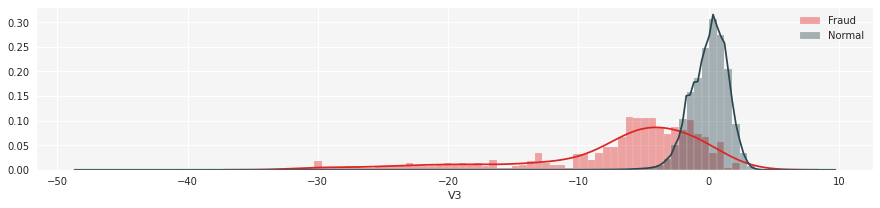

In [ ]:
checkdist('V3')

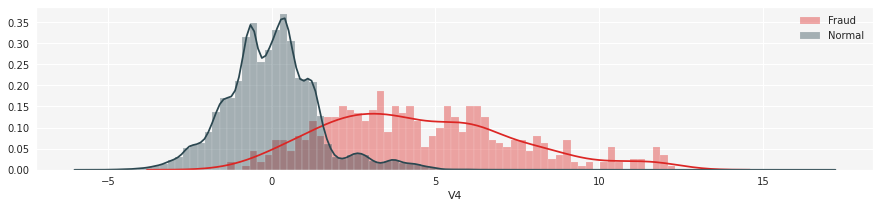

In [ ]:
checkdist('V4')

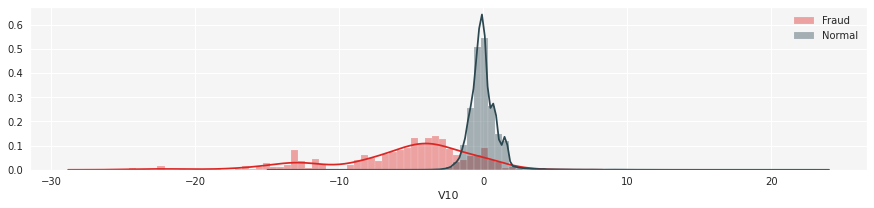

In [ ]:
checkdist('V10')

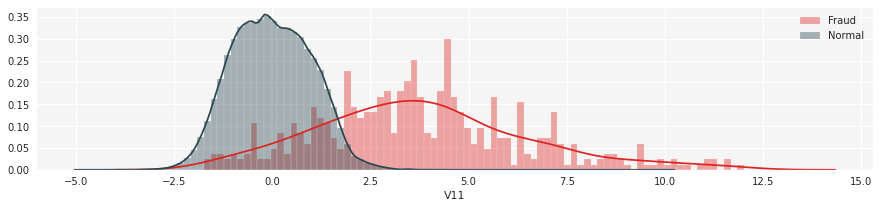

In [ ]:
checkdist('V11')

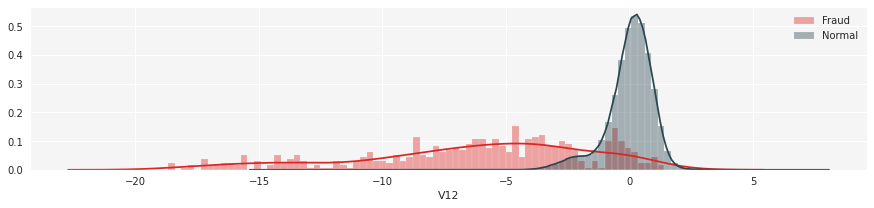

In [ ]:
checkdist('V12')

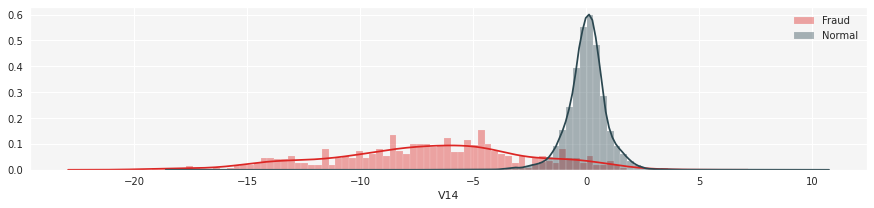

In [ ]:
checkdist('V14')

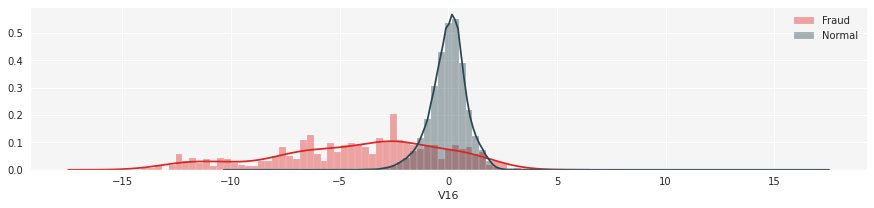

In [ ]:
checkdist('V16')

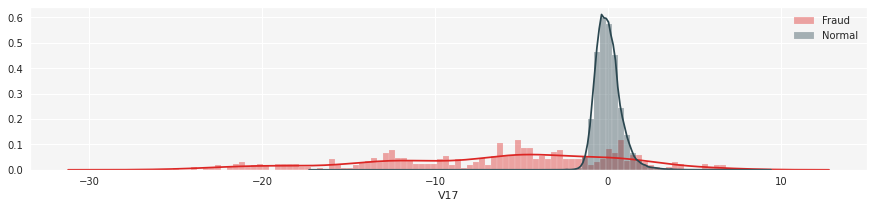

In [ ]:
checkdist('V17')

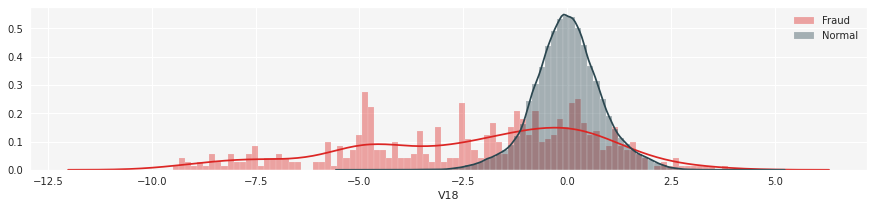

In [ ]:
checkdist('V18')

### 0.2.4 boxplot

In [ ]:
def box(featurename):
    fig, ax = plt.subplots(2, 1, figsize=(8,3), sharex=True);
    sns.boxplot(x=featurename, data=creditcard[creditcard['Class'] == 1], ax=ax[0], color = color[0]);
    ax[0].set_ylabel('Fraud');
    sns.boxplot(x=featurename, data=creditcard[creditcard['Class'] == 0], ax=ax[1], color = color[1]);
    ax[1].set_ylabel('Normal');

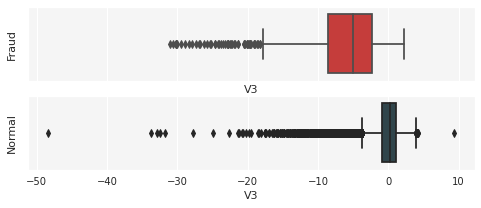

In [ ]:
box('V3')

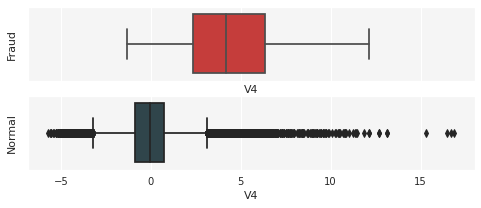

In [ ]:
box('V4')

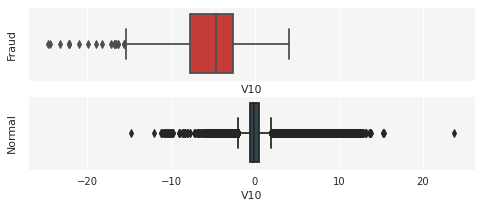

In [ ]:
box('V10')

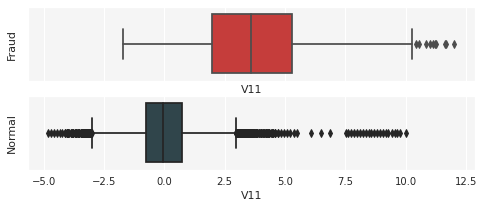

In [ ]:
box('V11')

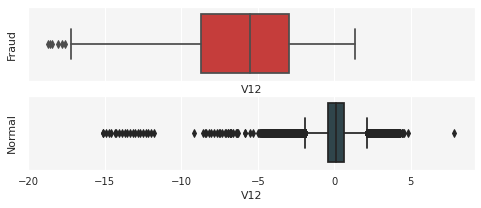

In [ ]:
box('V12')

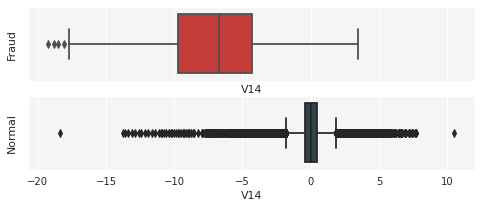

In [ ]:
box('V14')

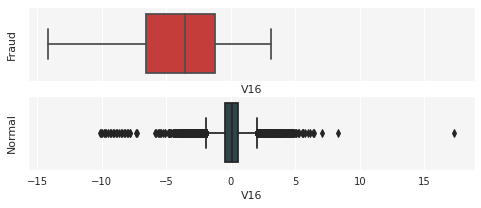

In [ ]:
box('V16')

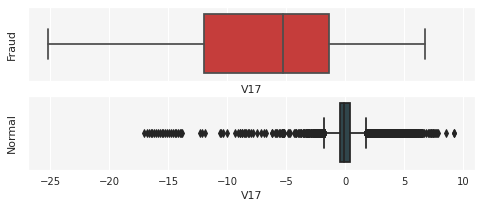

In [ ]:
box('V17')

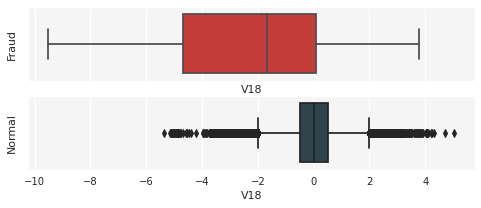

In [ ]:
box('V18')

# 1 特徵選擇

### 以納入Time的資料建模

In [ ]:
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class', 'HourInterval']

newcreditcard_Time = pd.get_dummies(creditcard[choose_col],drop_first=False)
newcreditcard_Time

,V3,V4,V10,V11,V12,V14,V16,V17,V18,Amount,Class,HourInterval_0:00,HourInterval_10:00,HourInterval_11:00,HourInterval_12:00,HourInterval_13:00,HourInterval_14:00,HourInterval_15:00,HourInterval_16:00,HourInterval_17:00,HourInterval_18:00,HourInterval_19:00,HourInterval_1:00,HourInterval_20:00,HourInterval_21:00,HourInterval_22:00,HourInterval_23:00,HourInterval_2:00,HourInterval_3:00,HourInterval_4:00,HourInterval_5:00,HourInterval_6:00,HourInterval_7:00,HourInterval_8:00,HourInterval_9:00
0,2.536347,1.378155,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,149.62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.166480,0.448154,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,2.69,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.773209,0.379780,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,378.66,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.792993,-0.863291,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,123.50,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.548718,0.403034,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,69.99,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-9.834783,-2.066656,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,0.77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
284803,2.035030,-0.738589,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,24.79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
284804,-3.249640,-0.557828,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,67.88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
284805,0.702510,0.689799,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,10.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


# 2 嘗試建模

## 2.1 k-Nearest Neighbor

In [ ]:
X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
%%time
recall = []
precision = []
k_numbers = list(range(15,45,2))

for k in k_numbers:
    model = make_pipeline( SMOTE(random_state=42), RobustScaler(), KNeighborsClassifier(n_neighbors = k, algorithm = 'auto') )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))

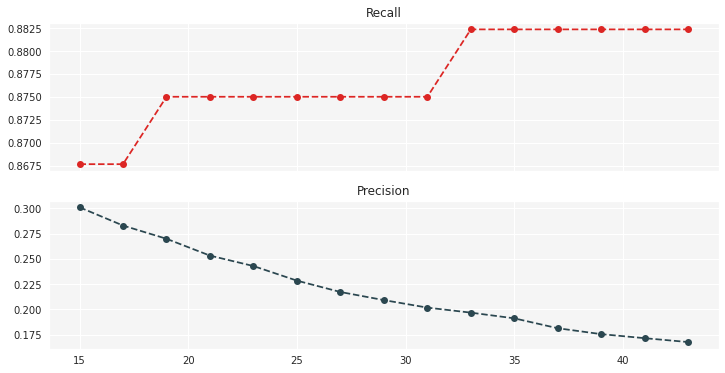

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,6),sharex=True);
ax[0].set_title('Recall')
ax[0].plot(k_numbers, recall, marker='o', ls='--', c=color[0]);
ax[1].set_title('Precision')
ax[1].plot(k_numbers, precision, marker='o', ls='--', c=color[1]);

CPU times: user 47min 59s, sys: 707 ms, total: 48min
Wall time: 48min 3s


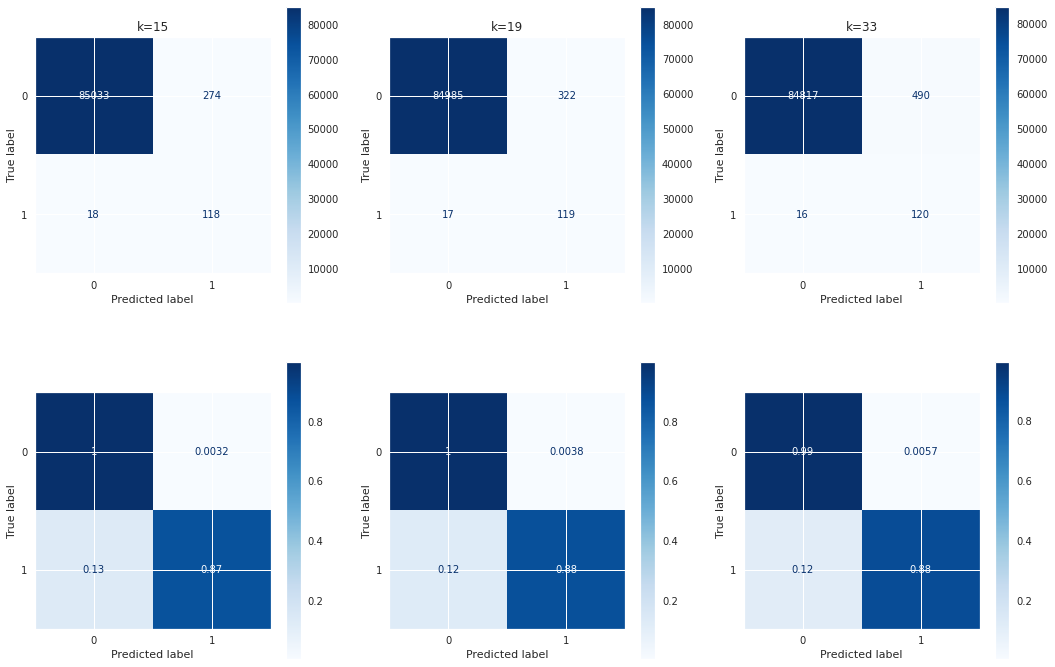

In [ ]:
%%time
k_numbers = [15,19,33]
yhat_list = []
rep_list = []
roc_auc_list = []

fig, ax = plt.subplots(2, len(k_numbers), figsize=(18,12));
for i in range(len(k_numbers)):
    model = make_pipeline( SMOTE(random_state=42), RobustScaler(), KNeighborsClassifier(n_neighbors = k_numbers[i], algorithm = 'auto') )
    model.fit(X_train, y_train)
    plot_confusion_matrix(model, X_test, y_test, ax=ax[0,i], cmap='Blues', values_format='d');
    plot_confusion_matrix(model, X_test, y_test, ax=ax[1,i], cmap='Blues', normalize='true');
    ax[0,i].set_title('k=%d' % k_numbers[i])

    yhat = model.predict(X_test)
    yhat_list.append(yhat)

    rep = classification_report(y_test, yhat_list[i])
    rep_list.append(rep)

    roc_auc = roc_auc_score(y_test, yhat_list[i])
    roc_auc_list.append(roc_auc)

In [ ]:
for i in range(len(k_numbers)):
    print('k=%d' % k_numbers[i])
    print(rep_list[i])
    print('ROC Score: %.2f' % roc_auc_list[i])
    print('-----------------------------------------------------')

k=15
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.30      0.87      0.45       136

    accuracy                           1.00     85443
   macro avg       0.65      0.93      0.72     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.93
-----------------------------------------------------
k=19
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.27      0.88      0.41       136

    accuracy                           1.00     85443
   macro avg       0.63      0.94      0.71     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.94
-----------------------------------------------------
k=33
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85307
           1       0.20      0.88      0.32       136

    accuracy               

### 拿掉Time
結果較好，但precision還是偏低。

In [ ]:
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

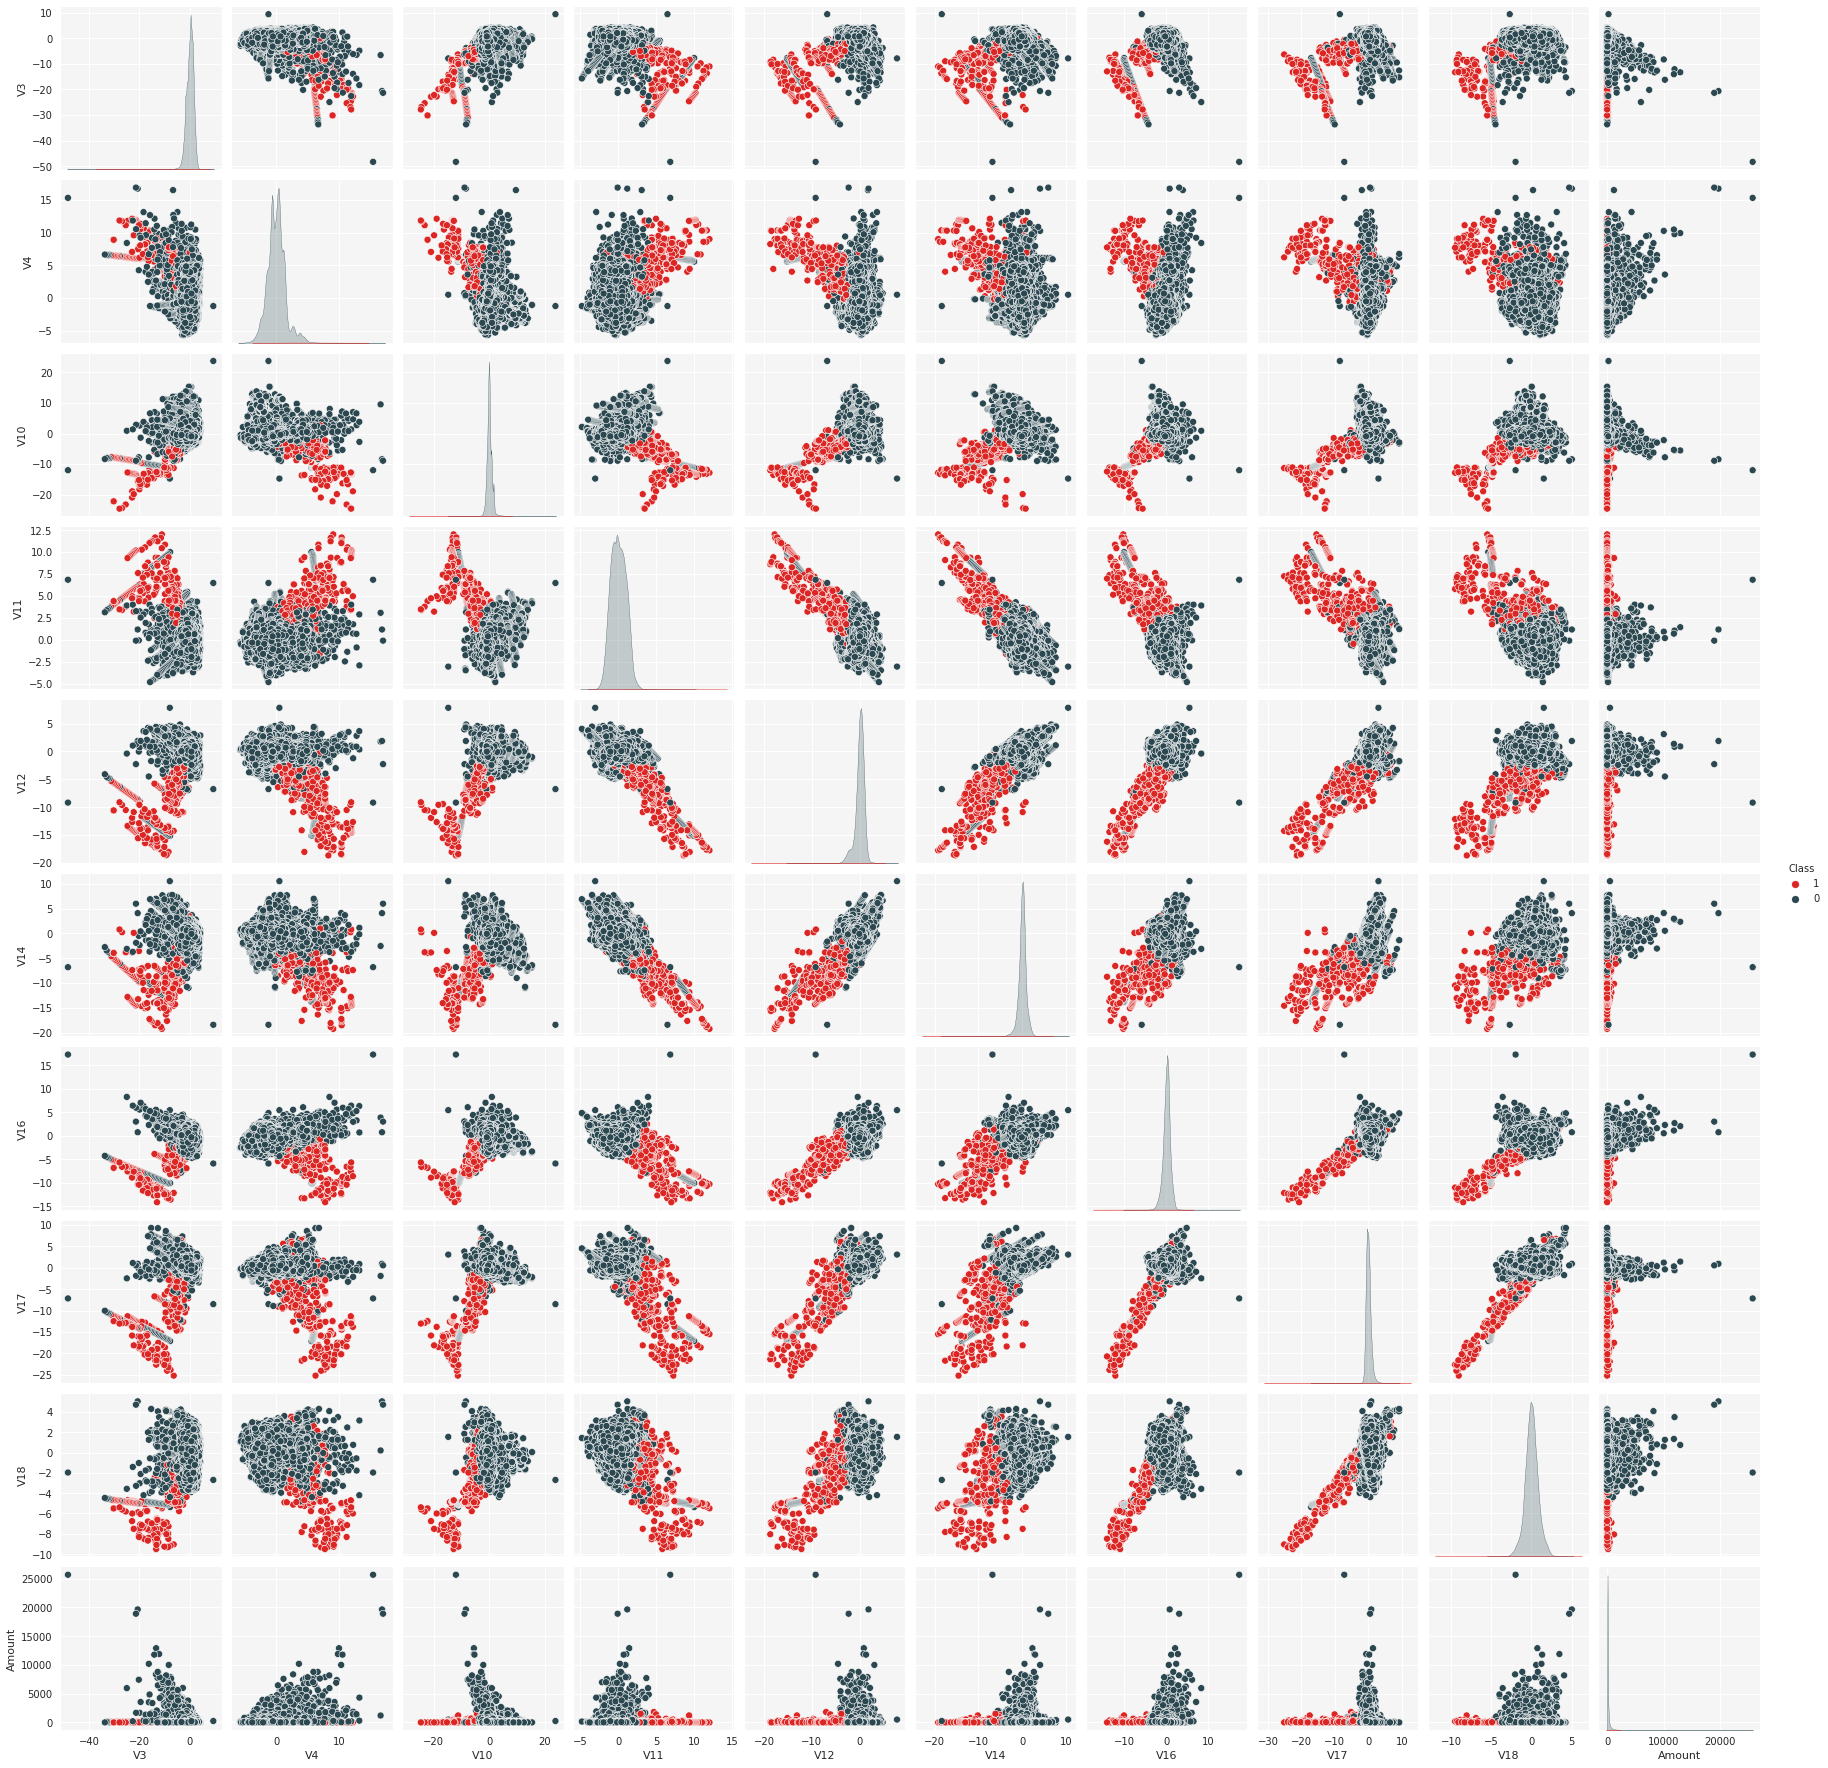

In [ ]:
sns.pairplot(newcreditcard, hue='Class', hue_order=[1,0]);

CPU times: user 12min 12s, sys: 291 ms, total: 12min 13s
Wall time: 12min 13s


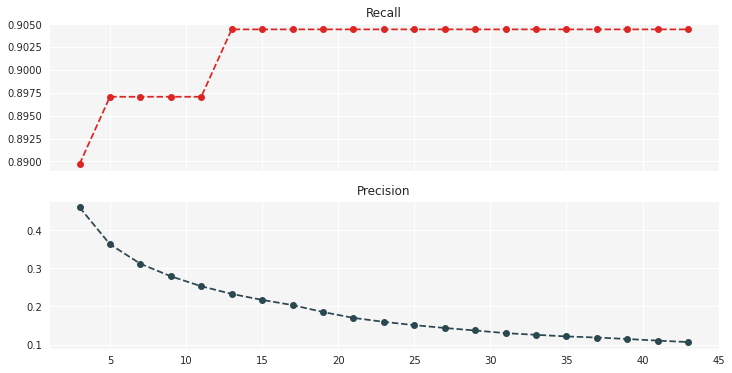

In [ ]:
%%time
recall = []
precision = []
k_numbers = list(range(3,45,2))

for k in k_numbers:
    model = make_pipeline( SMOTE(random_state=42), RobustScaler(), KNeighborsClassifier(n_neighbors = k, algorithm = 'auto') )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall.append(recall_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred))

fig, ax = plt.subplots(2,1,figsize=(12,6),sharex=True);
ax[0].set_title('Recall')
ax[0].plot(k_numbers, recall, marker='o', ls='--', c=color[0]);
ax[1].set_title('Precision')
ax[1].plot(k_numbers, precision, marker='o', ls='--', c=color[1]);

CPU times: user 3min 14s, sys: 82 ms, total: 3min 14s
Wall time: 3min 15s


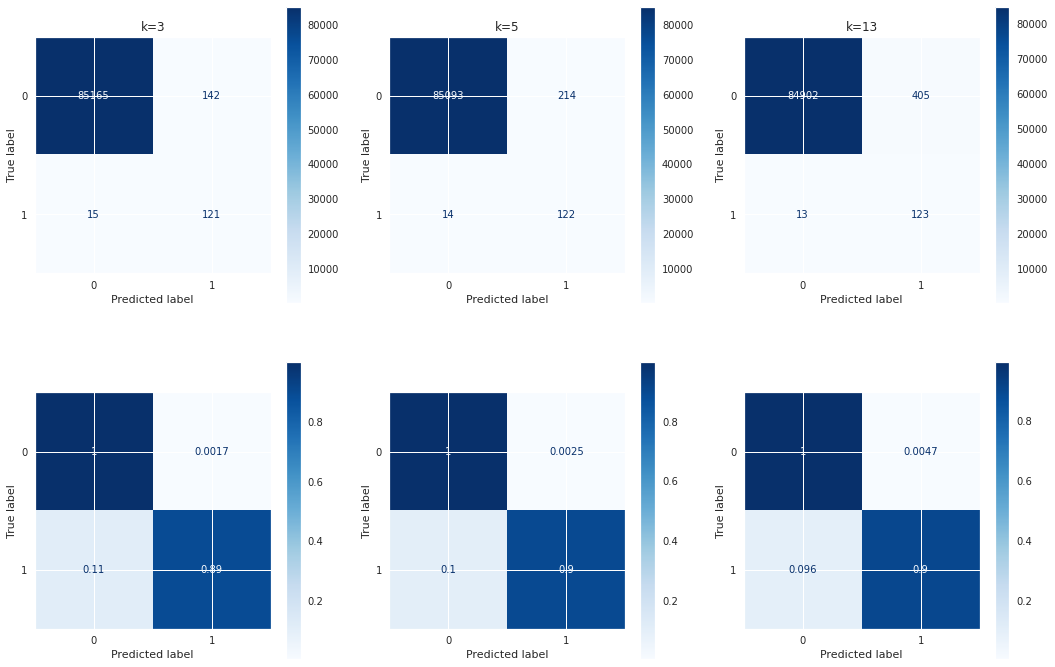

In [ ]:
%%time
k_numbers = [3,5,13]
yhat_list = []
rep_list = []
roc_auc_list = []

fig, ax = plt.subplots(2, len(k_numbers), figsize=(18,12));
for i in range(len(k_numbers)):
    model = make_pipeline( SMOTE(random_state=42), RobustScaler(), KNeighborsClassifier(n_neighbors = k_numbers[i], algorithm = 'auto') )
    model.fit(X_train, y_train)
    plot_confusion_matrix(model, X_test, y_test, ax=ax[0,i], cmap='Blues', values_format='d');
    plot_confusion_matrix(model, X_test, y_test, ax=ax[1,i], cmap='Blues', normalize='true');
    ax[0,i].set_title('k=%d' % k_numbers[i])

    yhat = model.predict(X_test)
    yhat_list.append(yhat)

    rep = classification_report(y_test, yhat_list[i])
    rep_list.append(rep)

    roc_auc = roc_auc_score(y_test, yhat_list[i])
    roc_auc_list.append(roc_auc)

In [ ]:
for i in range(len(k_numbers)):
    print('k=%d' % k_numbers[i])
    print(rep_list[i])
    print('ROC Score: %.2f' % roc_auc_list[i])
    print('-----------------------------------------------------')

k=3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.46      0.89      0.61       136

    accuracy                           1.00     85443
   macro avg       0.73      0.94      0.80     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.94
-----------------------------------------------------
k=5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.36      0.90      0.52       136

    accuracy                           1.00     85443
   macro avg       0.68      0.95      0.76     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.95
-----------------------------------------------------
k=13
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.23      0.90      0.37       136

    accuracy                 

## 2.1 Logistic Regression

In [ ]:
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18',
        'Amount', 'Class', 'HourInterval']

newcreditcard = pd.get_dummies(creditcard[choose_col],drop_first=False)

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85307
           1       0.06      0.93      0.11       136

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC Score: 0.95
CPU times: user 15.2 s, sys: 4.73 s, total: 20 s
Wall time: 11.3 s


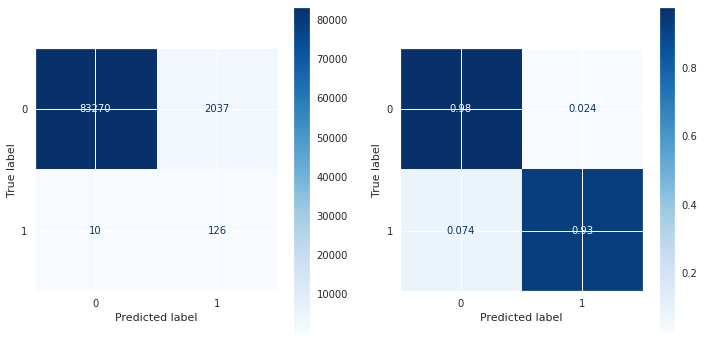

In [ ]:
%%time
model = make_pipeline( SMOTE(random_state=42), RobustScaler(), LogisticRegression() )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

### 拿掉Time

FP的數量比knn多很多，precision差

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85307
           1       0.07      0.93      0.12       136

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443

ROC Score: 0.95
CPU times: user 6.69 s, sys: 2.84 s, total: 9.53 s
Wall time: 5.6 s


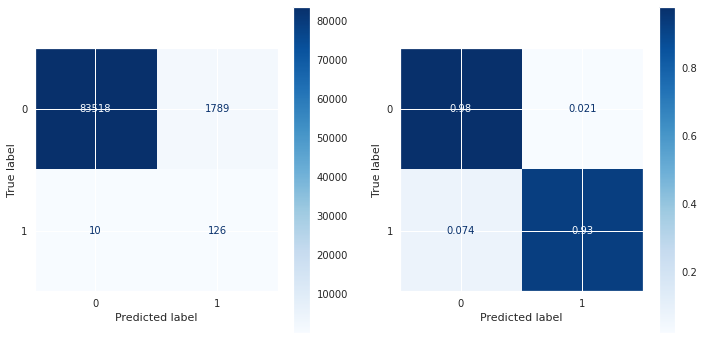

In [ ]:
%%time
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), LogisticRegression() )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

## 2.2 Support Vector Machine

評估後覺得Time只有兩天數據，也看不太出明顯規律，決定都不用Time當變量了。

### 不用kernel

上課筆記：特徵少但資料大的時候建議用SVM但不用任何Kernel。\
「不用任何Kernel」是指用默認的嗎? default是rbf

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.10      0.90      0.19       136

    accuracy                           0.99     85443
   macro avg       0.55      0.95      0.59     85443
weighted avg       1.00      0.99      0.99     85443

ROC Score: 0.95
CPU times: user 24min 22s, sys: 3.34 s, total: 24min 25s
Wall time: 24min 28s


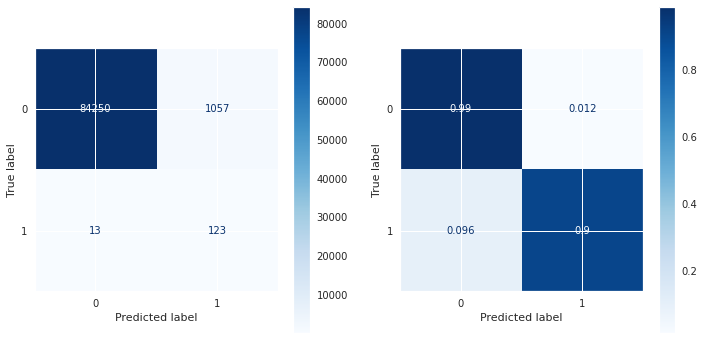

In [ ]:
%%time
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), SVC() )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

### 線性

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85307
           1       0.08      0.92      0.15       136

    accuracy                           0.98     85443
   macro avg       0.54      0.95      0.57     85443
weighted avg       1.00      0.98      0.99     85443

ROC Score: 0.95
CPU times: user 18min 51s, sys: 4.05 s, total: 18min 55s
Wall time: 18min 58s


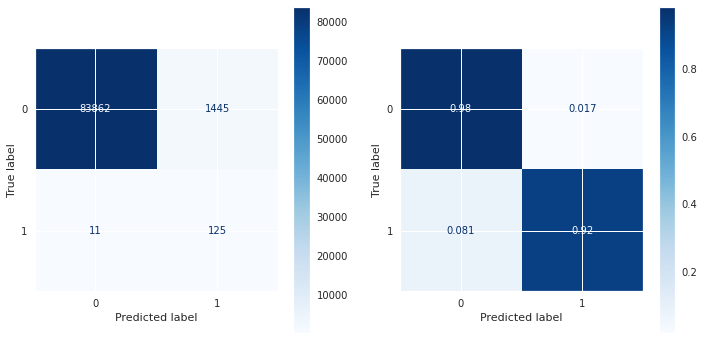

In [ ]:
%%time
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), SVC(kernel='linear') )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

## 2.3 Decision Tree

### gini

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.35      0.87      0.49       136

    accuracy                           1.00     85443
   macro avg       0.67      0.93      0.75     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.93
CPU times: user 14.4 s, sys: 16 ms, total: 14.5 s
Wall time: 14.5 s


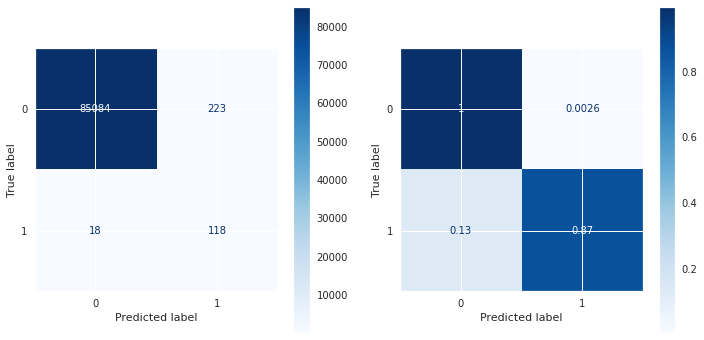

In [ ]:
%%time
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), DecisionTreeClassifier(criterion='gini') )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

### entropy

比gini好耶!

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.43      0.87      0.57       136

    accuracy                           1.00     85443
   macro avg       0.71      0.93      0.79     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.93
CPU times: user 13.4 s, sys: 15 ms, total: 13.4 s
Wall time: 13.4 s


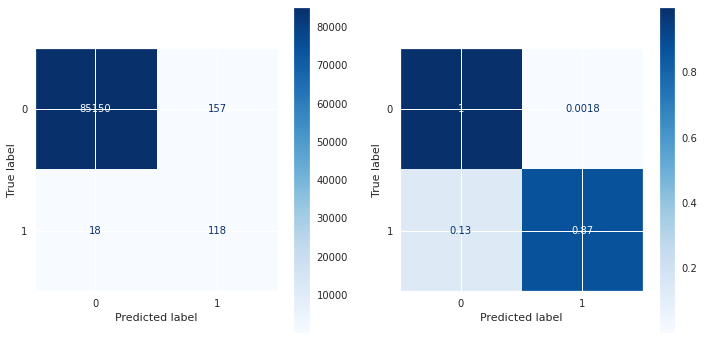

In [ ]:
%%time
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), DecisionTreeClassifier(criterion='entropy') )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

# 3 Ensemble Learning

## 3.1 隨機森林
結果意外的很不錯耶!!!

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.80      0.87      0.83       136

    accuracy                           1.00     85443
   macro avg       0.90      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.93
CPU times: user 4min 45s, sys: 189 ms, total: 4min 45s
Wall time: 4min 48s


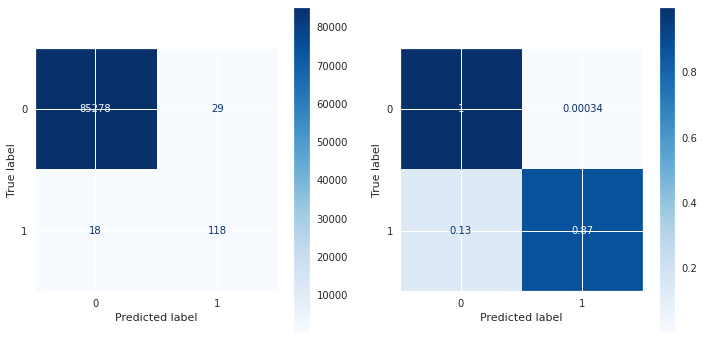

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), RandomForestClassifier(random_state=42) )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

## 3.2 AdaBoost

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85307
           1       0.06      0.93      0.11       136

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC Score: 0.95
CPU times: user 55.8 s, sys: 103 ms, total: 55.9 s
Wall time: 56 s


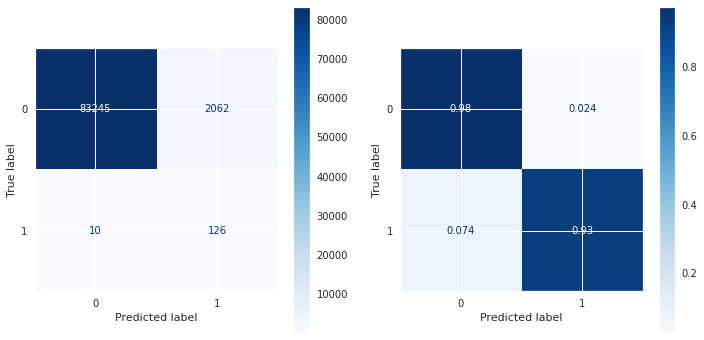

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier

choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), AdaBoostClassifier() )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

## 3.3 Gradient Boost

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.10      0.93      0.18       136

    accuracy                           0.99     85443
   macro avg       0.55      0.96      0.59     85443
weighted avg       1.00      0.99      0.99     85443

ROC Score: 0.96
CPU times: user 4min 18s, sys: 124 ms, total: 4min 18s
Wall time: 4min 19s


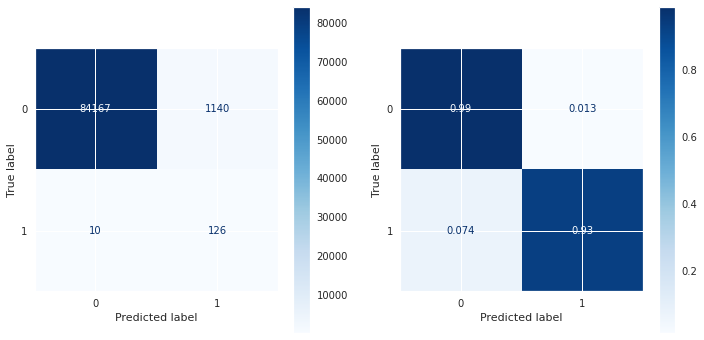

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), GradientBoostingClassifier() )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

## 3.4 XGBoost

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.10      0.93      0.19       136

    accuracy                           0.99     85443
   macro avg       0.55      0.96      0.59     85443
weighted avg       1.00      0.99      0.99     85443

ROC Score: 0.96
CPU times: user 45.8 s, sys: 93.9 ms, total: 45.9 s
Wall time: 46.1 s


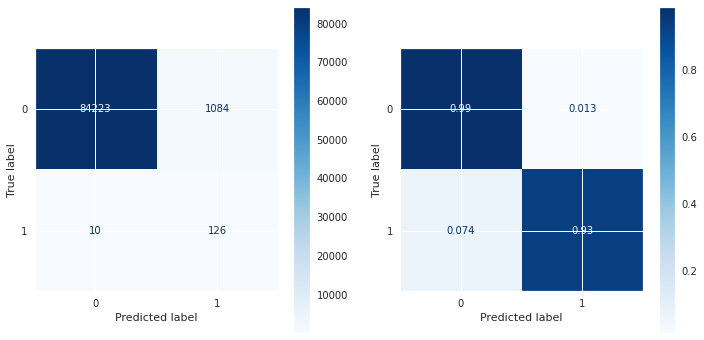

In [ ]:
%%time
from xgboost import XGBClassifier

choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = make_pipeline( SMOTE(random_state=42), RobustScaler(), XGBClassifier() )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

# 4 比較

## 4.1 交叉驗證及比較

綜合以上


1. Time對於模型沒什麼幫助
2. knn(k=3)和隨機森林的結果比較好



StratifiedKFold和Kfold很像，但StratifiedKFold可以保持訓練集、測試集的樣本分佈和原始資料一樣。

CPU times: user 1h 34min 57s, sys: 19.4 s, total: 1h 35min 17s
Wall time: 1h 35min 25s


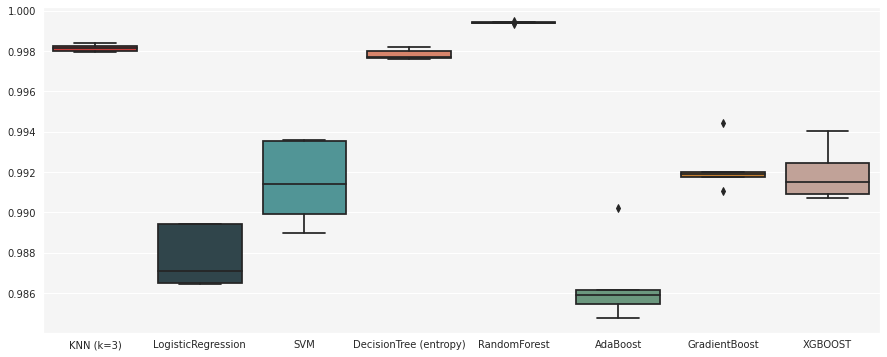

In [ ]:
%%time
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_1 = make_pipeline( SMOTE(random_state=42), RobustScaler(), KNeighborsClassifier(n_neighbors = 3, algorithm = 'auto') )
model_2 = make_pipeline( SMOTE(random_state=42), RobustScaler(), LogisticRegression() )
model_3 = make_pipeline( SMOTE(random_state=42), RobustScaler(), SVC() )
model_4 = make_pipeline( SMOTE(random_state=42), RobustScaler(), DecisionTreeClassifier(criterion='entropy') )
model_5 = make_pipeline( SMOTE(random_state=42), RobustScaler(), RandomForestClassifier() )
model_6 = make_pipeline( SMOTE(random_state=42), RobustScaler(), AdaBoostClassifier() )
model_7 = make_pipeline( SMOTE(random_state=42), RobustScaler(), GradientBoostingClassifier() )
model_8 = make_pipeline( SMOTE(random_state=42), RobustScaler(), XGBClassifier() )

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]
titles = ['KNN (k=3)',  'LogisticRegression', 'SVM', 'DecisionTree (entropy)', 'RandomForest', 'AdaBoost', 'GradientBoost', 'XGBOOST']

model_comp = pd.DataFrame()
cv = StratifiedKFold(n_splits=5)

for i, model in enumerate(models):
    model_comp[titles[i]] = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=cv)

fig, ax = plt.subplots(figsize=(15,6));
sns.boxplot(data=model_comp, ax=ax);

什麼都沒調的情況下，隨機森林表現最佳。

## 4.2 進一步調參

In [ ]:
RF = RandomForestClassifier()
RF.set_params()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
param_RF = {
    'RF__n_estimators':[10,50,100,500,750,1000,1500], #100

    'RF__max_depth':range(3,14,2), #None
    'RF__min_samples_split':range(50,201,20), #2

    'RF__min_samples_leaf':range(10,60,10), #1

    'RF__oob_score':[True,False], #False
    'RF__criterion':['gini','entropy'], #gini

    }

In [ ]:
choose_col = ['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'Amount', 'Class']
newcreditcard = creditcard[choose_col]

X = newcreditcard.drop(['Class'], axis=1).values
y = newcreditcard['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 調參1：n_estimators

In [ ]:
%%time
pipeline = Pipeline([ ( 'SMOTE',SMOTE(random_state=42) ),
            ( 'RobustScaler',RobustScaler() ),
            ( 'RF',RandomForestClassifier(random_state=42) ) ])

param_RF1 = {
    'RF__n_estimators':[10,50,100,500,750,1000,1500],
    }
RF_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_RF1, scoring='r2', cv=5)
RF_gsearch.fit(X_train, y_train)

print('best scores:', RF_gsearch.best_score_)
print('best params:', RF_gsearch.best_params_)

best scores: 0.6735955125399755
best params: {'RF__n_estimators': 750}
CPU times: user 7h 2min 10s, sys: 12.2 s, total: 7h 2min 22s
Wall time: 7h 2min 51s


In [ ]:
tmp = pd.DataFrame()
tmp['n_estimators'] = [10,50,100,500,750,1000,1500]
tmp['means'] = RF_gsearch.cv_results_['mean_test_score']
tmp['stds'] = RF_gsearch.cv_results_['std_test_score']
tmp

,n_estimators,means,stds
0,10,0.622957,0.029589
1,50,0.653920,0.022125
2,100,0.651137,0.035283
3,500,0.670774,0.028840
4,750,0.673596,0.023908
5,1000,0.667952,0.022771
6,1500,0.670734,0.029283


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.82      0.88      0.84       136

    accuracy                           1.00     85443
   macro avg       0.91      0.94      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC Score: 0.94
CPU times: user 19min 2s, sys: 667 ms, total: 19min 2s
Wall time: 19min 4s


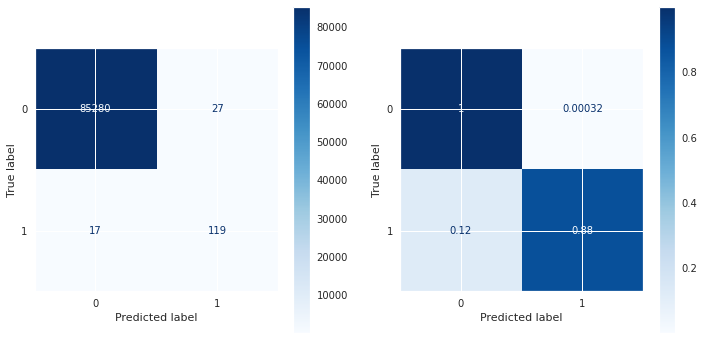

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(SMOTE(random_state=42),
            RobustScaler(),
            RandomForestClassifier(random_state=42,
                        n_estimators=750) )
model.fit(X_train, y_train)

yhat = model.predict(X_test)
rep = classification_report(y_test, yhat)
print(rep)

roc_auc = roc_auc_score(y_test, yhat)
print('ROC Score: %.2f' % roc_auc)

fig, ax = plt.subplots(1,2,figsize=(12,6));
plot_confusion_matrix(model, X_test, y_test, ax=ax[0], cmap='Blues', values_format='d');
plot_confusion_matrix(model, X_test, y_test, ax=ax[1], cmap='Blues', normalize='true');

### 調參2：max_depth、min_samples_split

In [ ]:
%%time
pipeline = Pipeline([ ( 'SMOTE',SMOTE(random_state=42) ),
            ( 'RobustScaler',RobustScaler() ),
            ( 'RF',RandomForestClassifier(random_state=42,
                            n_estimators=750) ) ])

param_RF2 = {
    'RF__max_depth':range(3,16,2),
    'RF__min_samples_split':range(50,201,20),
    }
RF_gsearch = GridSearchCV(estimator=pipeline, param_grid=param_RF2, scoring='r2', cv=5)
RF_gsearch.fit(X_train, y_train)

print('best scores:', RF_gsearch.best_score_)
print('best params:', RF_gsearch.best_params_)

### 4.3 建模預測